# Classification of Artwork

After going to the NY MoMA, I was inspired by their current exhibit (c. Dec 2017) on computer generated artwork dating back to the 70s. That's something I used to be really interested in, as I learned to program from a book on chaos and fractals. Thinking about what modern computer generated artwork would be liked, I was reminded of reverse gradient searches. I was interested in computer labeling of artwork a few years ago, but, fortunately, this time I managed to find a labeled dataset of paintings.

The Pandora data set can be found here: http://imag.pub.ro/pandora/pandora_download.html  
The following papers were published by the researchers about the data set and using it to try to label artwork.
- "Digital painting database for art movement recognition" http://imag.pub.ro/pandora/Download/Paintings_Intro_18K.pdf  
- "Pandora: Description of a Painting Database for Art Movement Recognition with Baselines and Perspectives" https://arxiv.org/pdf/1602.08855.pdf

At best they achieved about 45% accuracy.

Other papers of interest:
- "Identifying Emotions Aroused from Paintings:" http://infolab.stanford.edu/~wangz/project/imsearch/Aesthetics/ECCVW16/lu2.pdf

In [21]:
import numpy as np
import scipy.io as sio
from matplotlib import pylab as plt
%matplotlib inline
import tensorflow as tf

Heads up: if you're running inside of a docker image, you have to mount where you downloaded the data too! I spent five minutes debugging this line until I realized that the vm couldn't access my ~/Downloads directory >.< My image run command is
```sh
docker run -it -v `pwd`:/notebooks -v ~/Downloads:/data -v ~/Documents/Research/Misc/models/:/models -p 8888:8888 gcr.io/tensorflow/tensorflow
```
Now lets look at some of them.

In [6]:
base = "/data/"
mat = sio.loadmat(base+'Pandora18k_descripts/pandora18kMain_v2.mat')

In [26]:
mat['imageListFile'][2000][0][0][0]

(array([u'03_Northern_Renaissance\\hieronymus-bosch\\tempt-o1.jpg'],
      dtype='<U53'), array([[2]], dtype=uint8), array([[3]], dtype=uint8))

That's not very interesting data. The documentation doesn't even state what this file itself is supposed to be. Perhaps artist and class keys? The other mat files have the preprocessed image properties that are better described in the papers.

Let's look at a few random images:

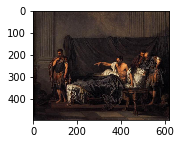

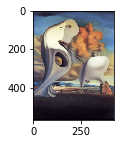

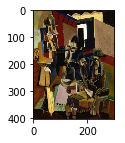

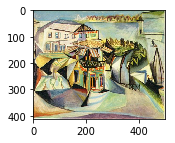

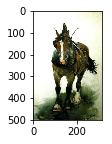

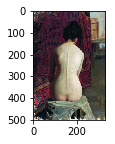

In [64]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)
from PIL import Image
TEST_IMAGE_PATHS = [
    '06_Rococo/Unidentified_artists/11635.jpg',
    '15_Surrealism/Salvador dali/Salvador Dali-26.jpg',
    '14_Cubism/Weber_Marc/the-visit.jpg',
    '14_Cubism/Picasso_Pablo/cafe-royan-1940.jpg',
    '08_Realism/tom-scott/horse-1890.jpg',
    '08_Realism/boris-kustodiev/nude.jpg'
]
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(base+'/Pandora_18k/'+image_path)
    image_np = load_image_into_numpy_array(image)
    plt.figure(figsize=(3,2))
    plt.imshow(image_np)
    plt.show()

## What's a feature?

The studies that developed the labeled database used different processed image properties, like color historgrams etc. They didn't get very good classification results. One thing they mentioned was not having enough data to train a DNN. Which is true. However, the meaning of artwork is more than just the corpus artwork itself. A painting is a representation of _something_ that humans interpret based on the rest of the world. A crucial descriptor of a piece of artwork is its subject. In humans, artwork evokes references from the rest of the world. There will never be enough data in a corpus of paintings to train subject matter. To interpret artwork, our model needs more than just the image properties; we need to include an object classifier that was trained on a larger body of real-world data.

Apparently that's easy now! [Following this blog](https://towardsdatascience.com/is-google-tensorflow-object-detection-api-the-easiest-way-to-implement-image-recognition-a8bd1f500ea0) I loaded up the object recognition model from the tensorflow [models repository](https://github.com/tensorflow/models/tree/master/research/object_detection)


In [9]:
import os
import sys
sys.path.append("/models/research")

In [7]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

This is how we download the model from the internet and load the labels from the locally mounted source directory:

In [29]:
CWD_PATH = '/models/research/'

MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'
# List of the strings that is used to add correct label for each box.
#PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

#PATH_TO_CKPT = os.path.join(CWD_PATH, 'object_detection', MODEL_NAME, 'frozen_inference_graph.pb')
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join(CWD_PATH, 'object_detection', 'data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

# Loading label map
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES,
                                                            use_display_name=True)
category_index = label_map_util.create_category_index(categories)

import six.moves.urllib as urllib
import tarfile
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

A wrapper for applying the modeling to an image:

In [49]:
def detect_objects(image_np, sess, detection_graph, threshhold=0.5):
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

    # Each box represents a part of the image where a particular object was detected.
    boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    scores = detection_graph.get_tensor_by_name('detection_scores:0')
    classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

    # Actual detection.
    (boxes, scores, classes, num_detections) = sess.run(
        [boxes, scores, classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})

    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        np.squeeze(boxes),
        np.squeeze(classes).astype(np.int32),
        np.squeeze(scores),
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=threshhold,
        line_thickness=8)
    return image_np

Load the graph from the expanded directory:

In [45]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

And make a new session and apply the object detection graph to our list of images and look at the results:

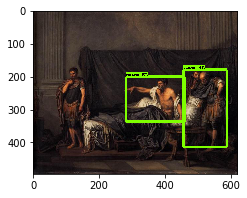

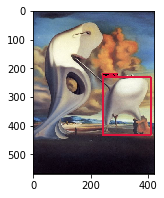

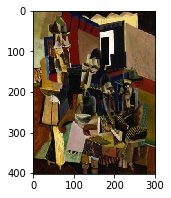

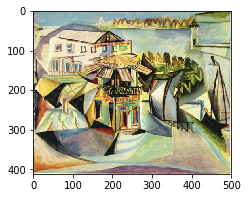

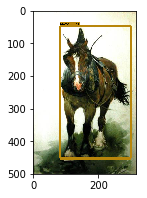

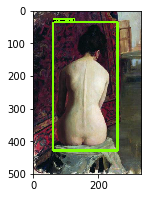

In [68]:
with tf.Session(graph=detection_graph) as sess:
    for image_path in TEST_IMAGE_PATHS:
        image = Image.open(base+'/Pandora_18k/'+image_path)
        image_np = load_image_into_numpy_array(image)
        detimg = detect_objects(image_np,sess,detection_graph)
        plt.figure(figsize=(4,3))
        plt.imshow(detimg)

Looks cool. But, someone of the paintings aren't marked at all and there are definitely other features in all of them that we aren't seeing. Let's change the threshold and see what comes up:

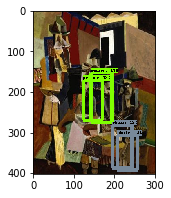

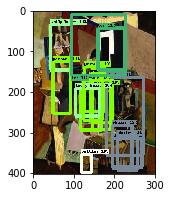

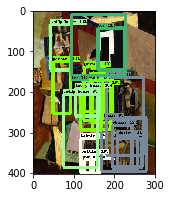

In [66]:
image_path = TEST_IMAGE_PATHS[2]
with tf.Session(graph=detection_graph) as sess:
    for thresh in [0.12,0.1,0.0001]:
        image = Image.open(base+'/Pandora_18k/'+image_path)
        image_np = load_image_into_numpy_array(image)
        detimg = detect_objects(image_np,sess,detection_graph,thresh)
        plt.figure(figsize=(4,3))
        plt.imshow(detimg)

Now that looks pretty cool. In this cubist painting, we see a few misidentifications and very low certainties. I hypothesize this a characterestic that a model could learn. (Low certainties, a wide distribution of weird objects.) 

Let's look at all of them with a very low threshhold:

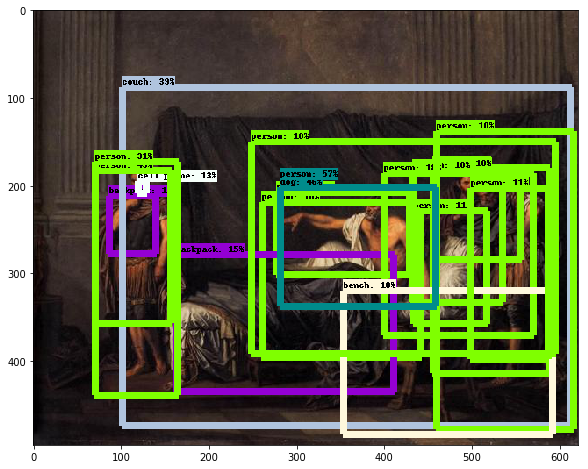

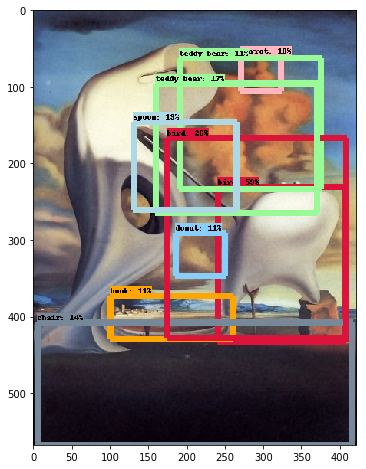

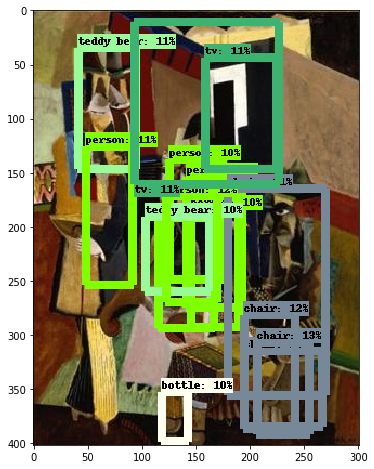

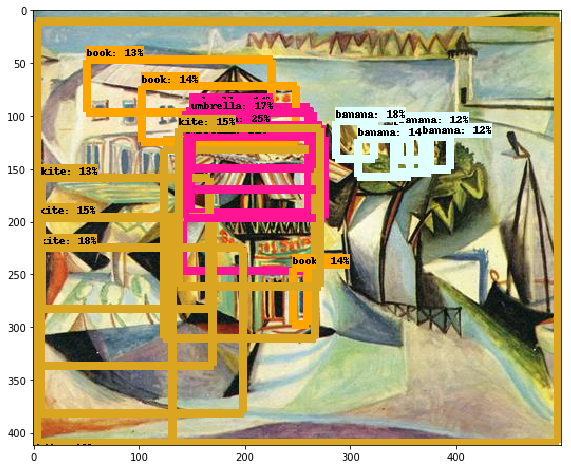

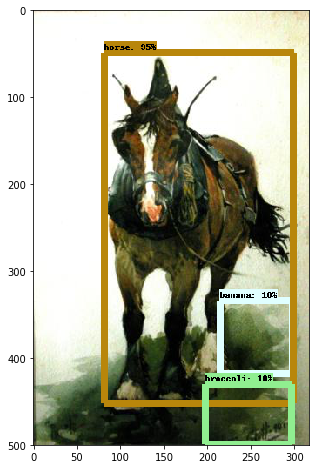

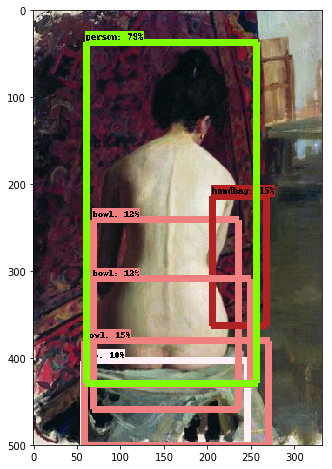

In [61]:
with tf.Session(graph=detection_graph) as sess:
    for image_path in TEST_IMAGE_PATHS:
        image = Image.open(base+'/Pandora_18k/'+image_path)
        image_np = load_image_into_numpy_array(image)
        detimg = detect_objects(image_np,sess,detection_graph,0.1)
        plt.figure(figsize=(12,8))
        plt.imshow(detimg)

The spatial distribution of objects also is an indicator of composition. E.g., look at the balance of identified objects in the first painting of the Rococo. 

Now I need to figure out how to encode these results as input to a model.